In [1]:
import numpy as np

import gym
from baselines.common.atari_wrappers import *

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from dqn_agent import Agent

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format='retina'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# loading the environment 
env = gym.make('Breakout-v0')

In [3]:
# using openai atari wrappers for preprocessing the input game image and stack frames
pp_env = wrap_deepmind(env,frame_stack=True)

Original game state shape: (210, 160, 3)
Processed game state shape: (84, 84, 4)


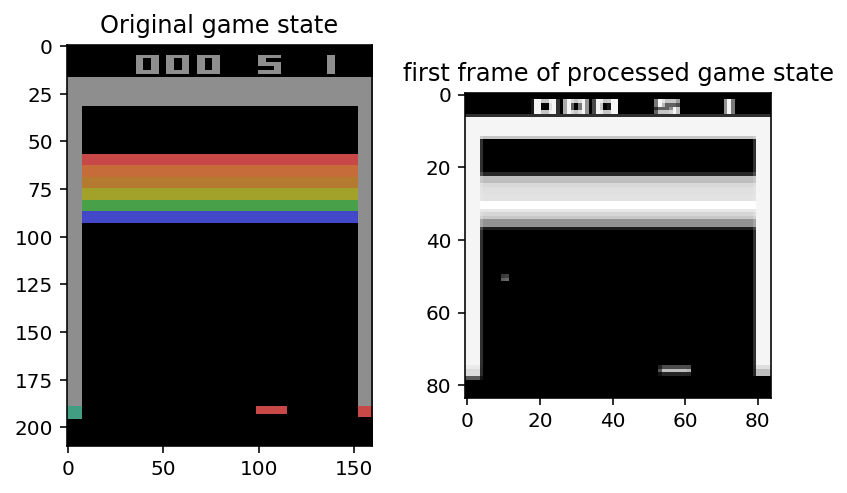

In [5]:
# lets see the difference between the original and preprocessed game state

orig_state = env.reset()
pp_state = np.array(pp_env.reset())

fig,ax = plt.subplots(nrows=1,ncols=2)

# orig game state
ax[0].imshow(orig_state)
ax[0].set_title('Original game state')
print ("Original game state shape: {}".format(orig_state.shape))

# processed game state
ax[1].imshow(pp_state[:,:,0],cmap='gray')
ax[1].set_title('first frame of processed game state')
print ("Processed game state shape: {}".format(pp_state.shape))

plt.tight_layout()
plt.show()

In [30]:
random_rewards = []

for _ in range(100):
    # lets play a random game
    state = pp_env.reset()
    done = False
    total_reward = 0
    step = 0
    while not done:
        pp_env.render()
        
        action = pp_env.action_space.sample()
            
        next_state,reward,done,_ = pp_env.step(action)
        
        # print step details
        #print ("step: {}\t action: {}\t reward: {}\t done: {}".format(step,action,reward,done))
        # update state and total reward
        state = next_state
        total_reward += reward
        step+=1
    
    random_rewards.append(total_reward)
pp_env.close()
print ("Avg reward for random play episode: {}".format(np.mean(random_rewards)))

Avg reward for random play episode: 0.22


In [ ]:
# initialising the agent
agent = Agent(state_shape=pp_env.observation_space.shape, action_size=pp_env.action_space.n,lr=2.5e-4)

from dqn_agent import REPLAY_START_SIZE

def evaluate_agent(agent):
    eval_score_list = []
    for _ in range(10):
        state = pp_env.reset()
        done = False
        eval_reward = 0
        while not done:
            action = agent.act(state,eps=0.1)
            next_state,reward,done,_ = pp_env.step(action)

            state = next_state
            eval_reward += reward
        eval_score_list.append(eval_reward)
    
    return np.mean(eval_score_list)

# training function
def dqn_train(max_episodes=1000,max_t=1000,eps_start=1.0,eps_end=1e-1,PRINT_EVERY=100):
    """
    trains the DQN agent

    Params
    ======
    max_episodes : max number of episodes for training the agent
    max_t : max number of timesteps for each episode to be used in training
    eps_start : starting value of epsilon
    eps_end : final value of epsilon

    """
    ACTION_EVERY = 4
    UPDATE_EVERY = 4
    MAX_EXPLORATION_FRAMES = 1e4
    
    eps_decay = np.exp(np.log(eps_end/eps_start)/MAX_EXPLORATION_FRAMES)
    
    eps = eps_start
    scores = []
    score_window = deque(maxlen=100)
    avg_scores = []

    for episode_count in range(1,max_episodes+1):

        # reset env state
        state = pp_env.reset()
        
        t_action = 0
        t_update = 0
        
        total_reward = 0
        for t in range(max_t) :
            if t_action == 0:
                # choose action using the local q-network
                action = agent.act(state,eps)
                
                # taking action in the env
                next_state,reward,done,_ = pp_env.step(action)

                # using agent to perform a learning step and save the sample in the memory
                agent.step(state,action,reward,next_state,done,t_update)

                # decay the epsilon value
                if len(agent.memory) > REPLAY_START_SIZE:
                    eps = max(eps_decay*eps,eps_end)
                
                # Update t_update
                t_update = (t_update+1) % UPDATE_EVERY
            
            else:
                # taking action in the env
                next_state,reward,done,_ = pp_env.step(action)
                
            
            # update action time step
            t_action = (t_action+1) % ACTION_EVERY
                
            # get total reward for the episode
            total_reward += reward

            # set current state = next_state
            state = next_state

            if done:
                break

        scores.append(total_reward)
        score_window.append(total_reward) 
        avg_scores.append(np.mean(score_window))

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_count, np.mean(score_window)), len(agent.memory),end="")
        if episode_count % PRINT_EVERY == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_count, np.mean(score_window)))
            eval_reward = evaluate_agent(agent)
            print("\nEpisode {}\tEval Score: {:.2f}\n".format(episode_count,eval_reward))

        if np.mean(score_window) > 13:
            print('\rLearning completed in {} episodes ... avg_score :{}'.format(episode_count, np.mean(score_window)))
            torch.save(agent.qnet_local.state_dict(), 'checkpoint_local.pth')
            break

    return agent,scores,avg_scores

In [ ]:
# training the dqn
trained_agent,scores,avg_scores = dqn_train(max_episodes=100000,PRINT_EVERY=100)

In [ ]:
# plotting the avg reward curve
plt.figure(figsize=(10,10))
plt.plot(range(len(avg_scores)),avg_scores)
plt.xlabel('episodes')
plt.ylabel('avg score for last 100 episodes')
plt.grid()
plt.show()

In [ ]:
# save trained agent weights
# torch.save(agent.qnet_local.state_dict(),"checkpoint_local.pth")

In [ ]:
# # uncomment this cell to load trained agent weights
# # initialising the agent
# trained_agent = Agent(state_size=brain.vector_observation_space_size, action_size=brain.vector_action_space_size)
# trained_agent.qnet_local.load_state_dict(torch.load('checkpoint_local.pth',map_location='cpu'))

In [ ]:
# lets visualise at how the trained agent performs

# reset env state
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]

done = env_info.local_done[0]
total_reward = 0

while not done:
    # choose action using the local q-network using low value of epsilon = 1e-2
    action = trained_agent.act(state,eps=1e-2)

    # taking action in the env
    env_info = env.step(vector_action=action)[brain_name]

    # getting next_state,reward,done from the env
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    
    # get total reward for the episode
    total_reward += reward
    
    # set current state = next_state
    state = next_state
    
print ("total reward : {:.2f}".format(total_reward))

In [ ]:
# closing the environment
env.close()

In [ ]:
m = nn.Conv2d(16, 33, 3, stride=1)
x = torch.randn(20, 16, 50, 100)
out = m(x)
out.shape

In [ ]:
len(trained_agent.memory)

In [ ]:
np.exp(np.log(0.1)/1e4)